In [1]:
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=4, processes=True, memory_limit='8GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58206,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:58220,Total threads: 4
Dashboard: http://127.0.0.1:58223/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:58209,


2025-03-16 15:15:08,295 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f7484cd3390442f2e4ce601637a54720 initialized by task ('hash-join-transfer-f7484cd3390442f2e4ce601637a54720', 99) executed on worker tcp://127.0.0.1:58219
2025-03-16 15:15:09,313 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 445d8a55ed702db5b65668aeafacd2ee initialized by task ('hash-join-transfer-445d8a55ed702db5b65668aeafacd2ee', 99) executed on worker tcp://127.0.0.1:58219
2025-03-16 15:15:10,507 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5e09e69fb9f187b09f5906387d483fb2 initialized by task ('hash-join-transfer-5e09e69fb9f187b09f5906387d483fb2', 99) executed on worker tcp://127.0.0.1:58219
2025-03-16 15:15:12,050 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6d9a4774c1e46122fd250236fb3f780a initialized by task ('hash-join-transfer-6d9a4774c1e46122fd250236fb3f780a', 99) executed on worker tcp://127.0.0.1:58219
2025-03-16 15:15:14,008 - distributed.shuffle._s

In [3]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
from tqdm import tqdm
import os

In [5]:
gems_file = 'gems_spent.csv' # gems spent by player
meta_sessions = 'meta_session_new.csv' # meta sessions filtred by game_id=1

In [7]:
extra_files = list(set([
    # 'main_tutorial_completed.csv',
    # 'dataset'
    # 'first_discipline.csv',
    # 'main_career_max_quest.csv',
    # 'tutorial_max_step.csv',
    # 'wild_cards_gained.csv',
    # 'wild_cards_spent.csv'
]))
files_to_join = [
    file for file in os.listdir('.')
    if file[:4] != 'meta' and
        file[-6:] != '.ipynb' and
        file[-4:] == '.csv' and
    file[0] != '.' and file not in extra_files
]
print(files_to_join)

['base_attribute_first_discipline.csv', 'duration.csv', 'energy_drink_gained.csv', 'energy_drink_spent.csv', 'energy_remained.csv', 'energy_spent.csv', 'first_discipline.csv', 'gems_remained.csv', 'gems_spent.csv', 'gp_gained.csv', 'gp_spent.csv', 'income.csv', 'level_end_of_session.csv', 'main_career_max_quest.csv', 'main_tutorial_completed.csv', 'money_gained.csv', 'money_spent.csv', 'order.csv', 'premium_shop_opened.csv', 'ranking_points_gained.csv', 'ranking_points_spent.csv', 'starts_remained.csv', 'starts_spent.csv', 'tutorial_max_step.csv', 'utp_gained.csv', 'utp_spent.csv', 'wild_cards_gained.csv', 'wild_cards_spent.csv']


In [9]:
def build_datasets(stats_df, useful_features, meta_sessions_file, persons_per_file=1_000, dir_path='cumsum_dataset.csv'):
    partition_size = '20MB'
    players = list(stats_df.index)
    players_df = dd.from_pandas(stats_df.reset_index(drop=False)[['oauth_user_games_id', 'player_metric']])

    if os.path.exists(dir_path):
        for filename in os.listdir(dir_path):
            os.remove(os.path.join(dir_path, filename))
        os.rmdir(dir_path)
    os.mkdir(dir_path)

    df = dd.read_csv(meta_sessions)[['id', 'oauth_user_games_id']]
    # df = dd.merge(left=ms, right=players_df, on='oauth_user_games_id').repartition(partition_size=partition_size)

    for file in useful_features:
        df = dd.merge(
            left=df,
            right=dd.read_csv(f"{file}.csv")[['session_id', 'value']].rename(columns={'value': file}),
            how='left',
            left_on='id',
            right_on='session_id'
        ).drop(columns='session_id')

    df = (
        dd.merge(
            left=(
                df
                .fillna(0)
                .groupby('oauth_user_games_id')
                .cumsum()
                .reset_index(drop=True)
            ),
            right=dd.read_csv(meta_sessions)[['id', 'oauth_user_games_id']],
            left_on='id',
            right_on='id',
            how='inner'
        )
    )
    print(df.columns)
    
    (
        dd.merge(
            left=df,
            right=players_df,
            how='left',
            left_on='oauth_user_games_id',
            right_on='oauth_user_games_id'
        )
        .to_csv(dir_path)
    )

In [11]:
ms = dd.read_csv(meta_sessions)[['oauth_user_games_id', 'id']]
ms.head()

,oauth_user_games_id,id
0,b5a428e4-7db6-41fd-b077-1839b6ec2739,1
1,df01daf9-9d3b-4d1c-90e9-143bb7d8230b,2
2,70a86cb0-7628-4b25-bca5-f7438f8ce0e7,3
3,207b4004-ed15-497e-8186-81823e19d862,4
4,da037477-5089-40dd-a802-4be16474c84f,5


In [13]:
result_df = ms[['oauth_user_games_id']].drop_duplicates()

for filename in tqdm(files_to_join):
    df = (
        dd.merge(left=ms, right=dd.read_csv(filename)[['session_id', 'value']], left_on='id', right_on='session_id', how='left')
        [['oauth_user_games_id', 'value']]
        .rename(columns={'value': filename[:-4]})
        .fillna(0)
        .groupby('oauth_user_games_id')
        .aggregate('sum')
    )
    result_df = dd.merge(left=result_df, right=df, how='left', on='oauth_user_games_id')

result_df = result_df.compute()
result_df.head()

100%|██████████| 28/28 [00:01<00:00, 21.07it/s]


,oauth_user_games_id,base_attribute_first_discipline,duration,energy_drink_gained,energy_drink_spent,energy_remained,energy_spent,first_discipline,gems_remained,gems_spent,...,premium_shop_opened,ranking_points_gained,ranking_points_spent,starts_remained,starts_spent,tutorial_max_step,utp_gained,utp_spent,wild_cards_gained,wild_cards_spent
0,e0297149-d630-43f1-872e-52f0d3b7dce2,114.0,47288.0,6.0,8.0,14822.0,1800.0,0.0,6648.0,442.0,...,8.0,3008.0,1136.0,912.0,928.0,1062.0,26940.0,10412.0,14.0,14.0
1,f58ccd89-c21d-461f-bcd7-28c49ab6712c,2182.0,38296.0,6.0,0.0,3312.0,22920.0,0.0,3130.0,0.0,...,4.0,4256.0,96.0,76.0,1100.0,476.0,109164.0,63978.0,12.0,2.0
2,ef370cbb-cb9b-48d3-93d8-b60072d1cfc9,40.0,10166.0,0.0,0.0,560.0,120.0,0.0,356.0,4.0,...,2.0,360.0,164.0,198.0,140.0,0.0,0.0,0.0,0.0,0.0
3,6d1f2dac-2213-4669-986a-d8ea9cb566dc,0.0,234.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,40.0,0.0,26.0,4.0,1064.0,0.0,0.0,0.0,0.0
4,db59dae4-20ad-4b5d-b604-36711f5cc343,261456.0,15060134.0,3648.0,3268.0,10797880.0,8212650.0,0.0,12311122.0,384808.0,...,4522.0,2235514.0,111394.0,431434.0,656020.0,0.0,749150586.0,745730876.0,7162.0,6826.0


In [14]:
result_df = result_df.set_index('oauth_user_games_id')

In [15]:
result_df.shape

(934987, 28)

In [16]:
result_df.columns

Index(['base_attribute_first_discipline', 'duration', 'energy_drink_gained',
       'energy_drink_spent', 'energy_remained', 'energy_spent',
       'first_discipline', 'gems_remained', 'gems_spent', 'gp_gained',
       'gp_spent', 'income', 'level_end_of_session', 'main_career_max_quest',
       'main_tutorial_completed', 'money_gained', 'money_spent', 'order',
       'premium_shop_opened', 'ranking_points_gained', 'ranking_points_spent',
       'starts_remained', 'starts_spent', 'tutorial_max_step', 'utp_gained',
       'utp_spent', 'wild_cards_gained', 'wild_cards_spent'],
      dtype='object')

In [17]:
result_df.to_csv('meta_aggregated_data.csv')
# result_df = pd.read_csv('meta_aggregated_data.csv')
# result_df = result_df.set_index('oauth_user_games_id')
result_df.head()

,base_attribute_first_discipline,duration,energy_drink_gained,energy_drink_spent,energy_remained,energy_spent,first_discipline,gems_remained,gems_spent,gp_gained,...,premium_shop_opened,ranking_points_gained,ranking_points_spent,starts_remained,starts_spent,tutorial_max_step,utp_gained,utp_spent,wild_cards_gained,wild_cards_spent
oauth_user_games_id,,,,,,,,,,,,,,,,,,,,,
e0297149-d630-43f1-872e-52f0d3b7dce2,114.0,47288.0,6.0,8.0,14822.0,1800.0,0.0,6648.0,442.0,66.0,...,8.0,3008.0,1136.0,912.0,928.0,1062.0,26940.0,10412.0,14.0,14.0
f58ccd89-c21d-461f-bcd7-28c49ab6712c,2182.0,38296.0,6.0,0.0,3312.0,22920.0,0.0,3130.0,0.0,146.0,...,4.0,4256.0,96.0,76.0,1100.0,476.0,109164.0,63978.0,12.0,2.0
ef370cbb-cb9b-48d3-93d8-b60072d1cfc9,40.0,10166.0,0.0,0.0,560.0,120.0,0.0,356.0,4.0,2.0,...,2.0,360.0,164.0,198.0,140.0,0.0,0.0,0.0,0.0,0.0
6d1f2dac-2213-4669-986a-d8ea9cb566dc,0.0,234.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,40.0,0.0,26.0,4.0,1064.0,0.0,0.0,0.0,0.0
db59dae4-20ad-4b5d-b604-36711f5cc343,261456.0,15060134.0,3648.0,3268.0,10797880.0,8212650.0,0.0,12311122.0,384808.0,43064.0,...,4522.0,2235514.0,111394.0,431434.0,656020.0,0.0,749150586.0,745730876.0,7162.0,6826.0


In [23]:
# result_df = result_df.drop('player_metric', axis=1)
corr_table = result_df.corr()
useful_features = list(corr_table[corr_table['gems_spent'].abs() > .3][['gems_spent']].index)
result_df['player_metric'] = result_df['gems_spent'] / result_df['gems_spent'].max()
useful_features

['base_attribute_first_discipline',
 'duration',
 'energy_drink_gained',
 'energy_drink_spent',
 'energy_spent',
 'gems_remained',
 'gems_spent',
 'gp_gained',
 'gp_spent',
 'income',
 'level_end_of_session',
 'money_gained',
 'money_spent',
 'order',
 'ranking_points_gained',
 'ranking_points_spent',
 'starts_spent',
 'utp_gained',
 'utp_spent',
 'wild_cards_gained',
 'wild_cards_spent']

In [25]:
build_datasets(result_df, useful_features, meta_sessions)

Index(['id', 'base_attribute_first_discipline', 'duration',
       'energy_drink_gained', 'energy_drink_spent', 'energy_spent',
       'gems_remained', 'gems_spent', 'gp_gained', 'gp_spent', 'income',
       'level_end_of_session', 'money_gained', 'money_spent', 'order',
       'ranking_points_gained', 'ranking_points_spent', 'starts_spent',
       'utp_gained', 'utp_spent', 'wild_cards_gained', 'wild_cards_spent',
       'oauth_user_games_id'],
      dtype='object')


C:\Users\tymof\anaconda3\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 48.84 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [26]:
dd.read_csv('cumsum_dataset.csv/*')[[*useful_features, 'player_metric']].mean().head(28)

base_attribute_first_discipline      62.953077
duration                           4002.733763
energy_drink_gained                   1.123484
energy_drink_spent                    0.271178
energy_spent                        945.966207
gems_remained                       314.989254
gems_spent                           29.954579
gp_gained                             5.018140
gp_spent                              4.422620
income                                0.009623
level_end_of_session                 37.769400
money_gained                       3747.973634
money_spent                        3723.904512
order                                95.432241
ranking_points_gained               246.953804
ranking_points_spent                 13.823982
starts_spent                         60.563794
utp_gained                         5298.788279
utp_spent                          3392.711645
wild_cards_gained                     1.081613
wild_cards_spent                      0.430536
player_metric

In [27]:
import seaborn as sns

In [28]:
dd.read_csv('cumsum_dataset.csv/*').head(n=10)

,Unnamed: 0,id,base_attribute_first_discipline,duration,energy_drink_gained,energy_drink_spent,energy_spent,gems_remained,gems_spent,gp_gained,...,order,ranking_points_gained,ranking_points_spent,starts_spent,utp_gained,utp_spent,wild_cards_gained,wild_cards_spent,oauth_user_games_id,player_metric
0,0,336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5cdd5bf6-96df-4354-8693-8e7dfdeaf0fe,0.000000
1,1,336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5cdd5bf6-96df-4354-8693-8e7dfdeaf0fe,0.000000
2,2,577,0.0,1150.0,0.0,0.0,0.0,70.0,0.0,1.0,...,1.0,60.0,20.0,14.0,0.0,0.0,0.0,0.0,4ff494df-264e-4705-8fe5-18d6d548960c,0.000000
3,3,577,0.0,1150.0,0.0,0.0,0.0,70.0,0.0,1.0,...,1.0,60.0,20.0,14.0,0.0,0.0,0.0,0.0,4ff494df-264e-4705-8fe5-18d6d548960c,0.000000
4,4,581,0.0,1485.0,0.0,0.0,240.0,0.0,0.0,2.0,...,1.0,49.0,8.0,15.0,4857.0,3928.0,0.0,0.0,d780ebbe-f78d-4408-a26c-9907ef9e7889,0.004017
5,5,581,0.0,1485.0,0.0,0.0,240.0,0.0,0.0,2.0,...,1.0,49.0,8.0,15.0,4857.0,3928.0,0.0,0.0,d780ebbe-f78d-4408-a26c-9907ef9e7889,0.004017
6,6,588,13.0,619.0,0.0,0.0,320.0,60.0,0.0,0.0,...,1.0,10.0,0.0,11.0,1000.0,666.0,0.0,0.0,07125317-da0b-4bd0-ae62-1a5eb6b81a6f,0.000000
7,7,588,13.0,619.0,0.0,0.0,320.0,60.0,0.0,0.0,...,1.0,10.0,0.0,11.0,1000.0,666.0,0.0,0.0,07125317-da0b-4bd0-ae62-1a5eb6b81a6f,0.000000
8,8,624,10.0,28.0,0.0,0.0,200.0,0.0,0.0,0.0,...,1.0,0.0,0.0,10.0,0.0,500.0,0.0,0.0,37a94601-45f2-46d6-9597-92167dbcd45d,0.000000
9,9,624,10.0,28.0,0.0,0.0,200.0,0.0,0.0,0.0,...,1.0,0.0,0.0,10.0,0.0,500.0,0.0,0.0,37a94601-45f2-46d6-9597-92167dbcd45d,0.000000


<Axes: ylabel='Count'>

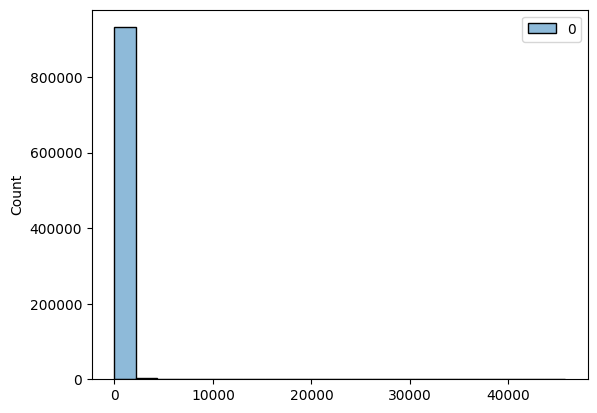

In [29]:
sns.histplot(
    dd.read_csv('cumsum_dataset.csv/*')
    [['oauth_user_games_id', 'gems_spent']]
    .groupby('oauth_user_games_id')
    .max()
    [['gems_spent']]
    .compute()
    .values
)

In [30]:
player_metrics = (
    dd.read_csv('cumsum_dataset.csv/*')
    [['oauth_user_games_id', 'player_metric']]
    .drop_duplicates(
        subset=['oauth_user_games_id']
    ).compute()
)

In [31]:
# player_metrics = player_metrics[['player_metric']]
player_metrics.head()

,oauth_user_games_id,player_metric
460,461a3059-895a-4428-a8d5-4c8eece10d00,0.0
506,22894ddd-9d7d-4340-bc85-f4fc46823a73,0.0
660,edcd4275-3d0c-4aa4-bfaa-c079e77c5b3d,0.0
666,1d178e11-5200-49d1-9dd7-216665f97991,0.0
800,e87512bf-3c43-4657-898e-792f5002a326,0.0


In [32]:
import seaborn as sns

<Axes: ylabel='Count'>

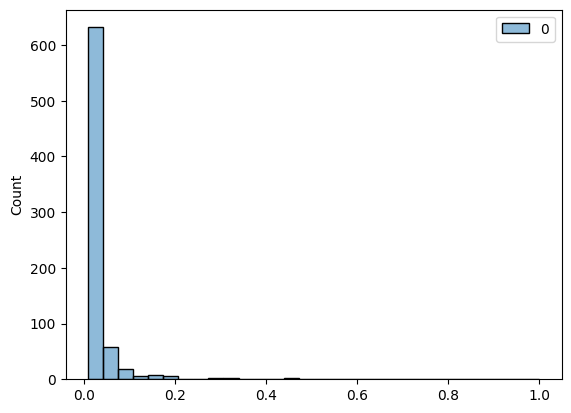

In [33]:
sns.histplot(player_metrics[player_metrics['player_metric'] > 0.01][['player_metric']].values, bins=30)

In [34]:
import math

In [35]:
df = (
    dd.read_csv('cumsum_dataset.csv/*')
    [['oauth_user_games_id', 'duration']]
    .groupby('oauth_user_games_id')
    .agg('max')
    .compute()
)
m = df.median()['duration']
print(m)

454.0


In [36]:
# Creating resulting dataset
df = (
    dd.read_csv('cumsum_dataset.csv/*')
    .drop(['Unnamed: 0', 'id', 'oauth_user_games_id'], axis=1)
    .dropna()
)
columns = [x for x in df.columns if x != 'player_metric']

df = df[(df['duration'] > m) & (df['player_metric'] > 0.001)]

for c in columns:
    df[c] = df[c].apply(math.tanh, meta=(c, 'float64'))

df.to_csv('result_dataset.csv', single_file=True, index=False)

['C:\\Users\\tymof\\Downloads\\любимая тонечка\\result_dataset.csv']

In [37]:
df.head()

,base_attribute_first_discipline,duration,energy_drink_gained,energy_drink_spent,energy_spent,gems_remained,gems_spent,gp_gained,gp_spent,income,...,money_spent,order,ranking_points_gained,ranking_points_spent,starts_spent,utp_gained,utp_spent,wild_cards_gained,wild_cards_spent,player_metric
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.964028,0.964028,0.0,...,1.0,0.761594,1.0,1.000000,1.000000,1.0,1.0,0.000000,0.0,0.004017
5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.964028,0.964028,0.0,...,1.0,0.761594,1.0,1.000000,1.000000,1.0,1.0,0.000000,0.0,0.004017
26,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.999909,1.000000,0.0,...,0.0,0.964028,1.0,0.999909,1.000000,1.0,1.0,0.000000,0.0,0.013218
27,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.999909,1.000000,0.0,...,0.0,0.964028,1.0,0.999909,1.000000,1.0,1.0,0.000000,0.0,0.013218
38,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.761594,0.0,...,0.0,0.761594,1.0,0.761594,0.999909,0.0,0.0,0.761594,0.0,0.012359


In [38]:
pd.read_csv('result_dataset.csv').shape

(2858981, 22)